In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('div.output_stderr').hide();
 } else {
 $('div.input').show();
 $('div.output_stderr').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action='javascript:code_toggle()'><input STYLE='color: #4286f4' type='submit' value='Click here to toggle on/off the raw code.'></form>''')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import sys
sys.path.append('..')  # to be able to import spectral_connectivity

from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity

In [5]:
def simulate_MVAR(coefficients, noise_covariance=None, n_time_samples=100,
                  n_trials=1, n_burnin_samples=100):
    '''
    Parameters
    ----------
    coefficients : array, shape (n_time_samples, n_lags, n_signals, n_signals)
    noise_covariance : array, shape (n_signals, n_signals)
    
    Returns
    -------
    time_series : array, shape (n_time_samples - n_burnin_samples,
                                n_trials, n_signals)

    '''
    n_lags, n_signals, _ = coefficients.shape
    if noise_covariance is None:
        noise_covariance = np.eye(n_signals)
    time_series = np.random.multivariate_normal(
        np.zeros((n_signals,)), noise_covariance,
        size=(n_time_samples + n_burnin_samples, n_trials))
    
    for time_ind in np.arange(n_lags, n_time_samples + n_burnin_samples):
        for lag_ind in np.arange(n_lags):
            time_series[time_ind, ...] += np.matmul(
                coefficients[np.newaxis, np.newaxis, lag_ind, ...],
                time_series[time_ind - (lag_ind + 1), ..., np.newaxis]).squeeze()
    return time_series[n_burnin_samples:, ...]


def simulate_MVAR2(coefficients, noise_covariance=None, n_trials=1,
                  n_burnin_samples=100, n_time_samples=500):
    """Simulate MVAR process
    Parameters
    ----------
    A : ndarray, shape (p, N, N)
        The AR coefficients where N is the number of signals
        and p the order of the model.
    n : int
        The number of time samples.
    sigma : array, shape (N,)
        The noise for each time series
    burnin : int
        The length of the burnin period (in samples).
    Returns
    -------
    X : ndarray, shape (N, n)
        The N time series of length n
    """
    n_lags, n_signals, _ = coefficients.shape
    A_2d = np.concatenate(coefficients, axis=1)
    time_series = np.zeros((n_time_samples + n_burnin_samples, n_signals))

    for time_ind in range(n_lags, n_time_samples + n_burnin_samples):
        noise = np.random.multivariate_normal(np.zeros((n_signals,)), noise_covariance)
        time_series[time_ind] = np.dot(
            A_2d,
            time_series[time_ind - n_lags:time_ind][::-1, :].ravel()) + noise

    return time_series[n_burnin_samples:]

In [6]:
def plot_directional(time_series, sampling_frequency, time_halfbandwidth_product=2):
    m = Multitaper(time_series,
                   sampling_frequency=sampling_frequency,
                   time_halfbandwidth_product=time_halfbandwidth_product,
                   start_time=0)
    c = Connectivity(fourier_coefficients=m.fft(),
                     frequencies=m.frequencies,
                     time=m.time)

    measures = dict(
        pairwise_spectral_granger=c.pairwise_spectral_granger_prediction(),
        directed_transfer_function=c.directed_transfer_function(),
        partial_directed_coherence=c.partial_directed_coherence(),
        generalized_partial_directed_coherence=c.generalized_partial_directed_coherence(),
        direct_directed_transfer_function=c.direct_directed_transfer_function(),
    )

    n_signals = time_series.shape[-1]
    signal_ind2, signal_ind1 = np.meshgrid(np.arange(n_signals), np.arange(n_signals))

    fig, axes = plt.subplots(n_signals, n_signals, figsize=(n_signals * 3, n_signals * 3), sharex=True)
    for ind1, ind2, ax in zip(signal_ind1.ravel(), signal_ind2.ravel(), axes.ravel()):
        for measure_name, measure in measures.items():
            ax.plot(c.frequencies, measure[0, :, ind1, ind2], label=measure_name,
                    linewidth=5, alpha=0.8)
        ax.set_title('x{} → x{}'.format(ind2 + 1, ind1 + 1), fontsize=15)
        ax.set_ylim((0, np.max([np.nanmax(np.stack(measures.values())), 1.05])))

    axes[0, -1].legend();
    plt.tight_layout()
    
    fig, axes = plt.subplots(1, 1, figsize=(3, 3), sharex=True, sharey=True)
    axes.plot(c.frequencies, c.power.squeeze())
    plt.title('Power')

## Baccala Example 2

> Baccalá, L.A., and Sameshima, K. (2001). Partial directed coherence:
    a new concept in neural structure determination. Biological
    Cybernetics 84, 463–474.


$$x_1 = 0.5x_1(n-1) + 0.3x_2(n-1) + 0.4x_3x(n-1) + w_1(n)$$

$$x_2 = -0.5x_1(n-1) + 0.3x_2(n-1) + 1.0x_3x(n-1) + w_2(n)$$

$$x_3 = -0.3x_2(n-1) - 0.2x_3x(n-1) + w_3(n)$$

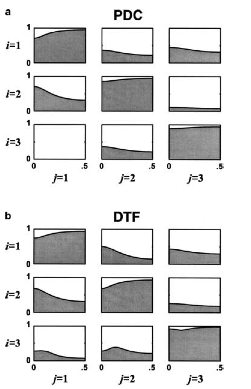

/home/ulianych/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/ulianych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/ulianych/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:954: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 1] = interval


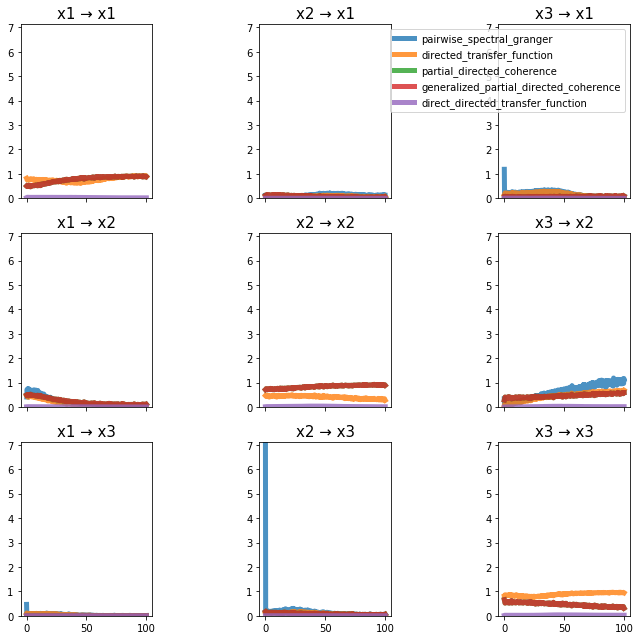

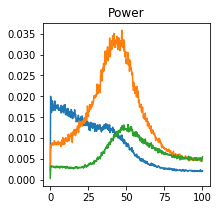

In [7]:
def baccala_example2():
    '''Baccalá, L.A., and Sameshima, K. (2001). Partial directed coherence:
    a new concept in neural structure determination. Biological
    Cybernetics 84, 463–474.
    '''
    sampling_frequency = 200
    n_time_samples, n_lags, n_signals = 1000, 1, 3

    coefficients = np.array(
        [[[ 0.5,  0.3,  0.4],
          [-0.5,  0.3,  1. ],
          [ 0. , -0.3, -0.2]]])

    noise_covariance = np.eye(n_signals)

    return simulate_MVAR(
        coefficients, noise_covariance=noise_covariance, n_time_samples=n_time_samples,
        n_trials=500, n_burnin_samples=500), sampling_frequency

plot_directional(*baccala_example2(), time_halfbandwidth_product=1)

## Baccala Example 3

> Baccalá, L.A., and Sameshima, K. (2001). Partial directed coherence:
    a new concept in neural structure determination. Biological
    Cybernetics 84, 463–474.

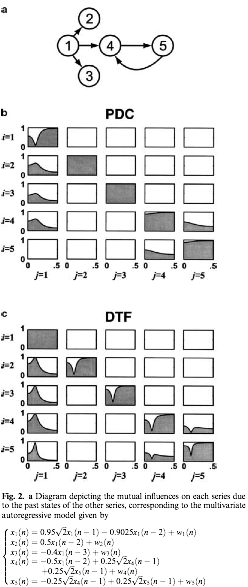

/home/ulianych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


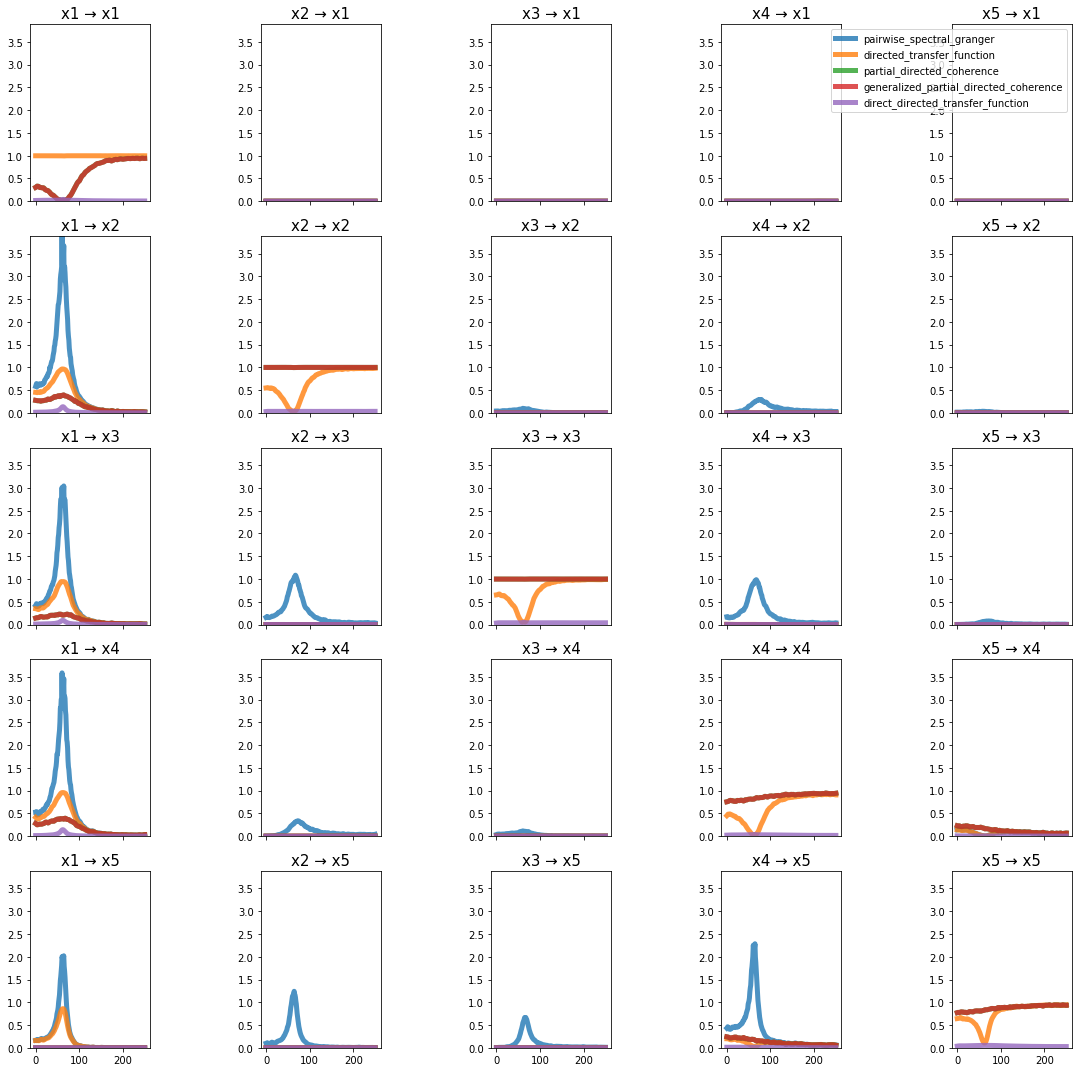

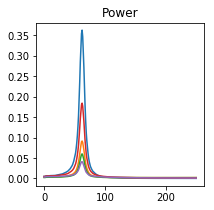

In [8]:
def baccala_example3():
    '''Baccalá, L.A., and Sameshima, K. (2001). Partial directed coherence:
    a new concept in neural structure determination. Biological
    Cybernetics 84, 463–474.
    '''
    sampling_frequency = 500
    n_time_samples, n_lags, n_signals = 510, 3, 5
    coefficients = np.zeros((n_lags, n_signals, n_signals))

    coefficients[0, 0, 0] = 0.95 * np.sqrt(2)
    coefficients[1, 0, 0] = -0.9025

    coefficients[1, 1, 0] = 0.50
    coefficients[2, 2, 0] = -0.40

    coefficients[1, 3, 0] = -0.5
    coefficients[0, 3, 3] = 0.25 * np.sqrt(2)
    coefficients[0, 3, 4] = 0.25 * np.sqrt(2)

    coefficients[0, 4, 3] = -0.25 * np.sqrt(2)
    coefficients[0, 4, 4] = 0.25 * np.sqrt(2)

    noise_covariance = None
    
    return simulate_MVAR(
        coefficients, noise_covariance=noise_covariance, n_time_samples=n_time_samples,
        n_trials=500, n_burnin_samples=500), sampling_frequency

plot_directional(*baccala_example3(), time_halfbandwidth_product=3)

## Baccala Example 4

> Baccalá, L.A., and Sameshima, K. (2001). Partial directed coherence:
    a new concept in neural structure determination. Biological
    Cybernetics 84, 463–474.

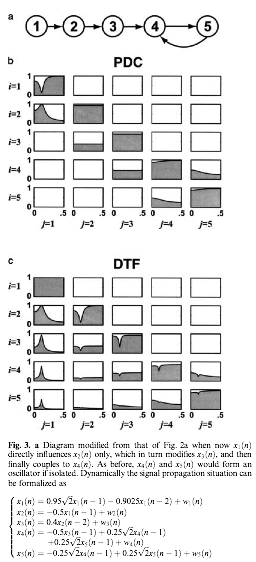

/home/ulianych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


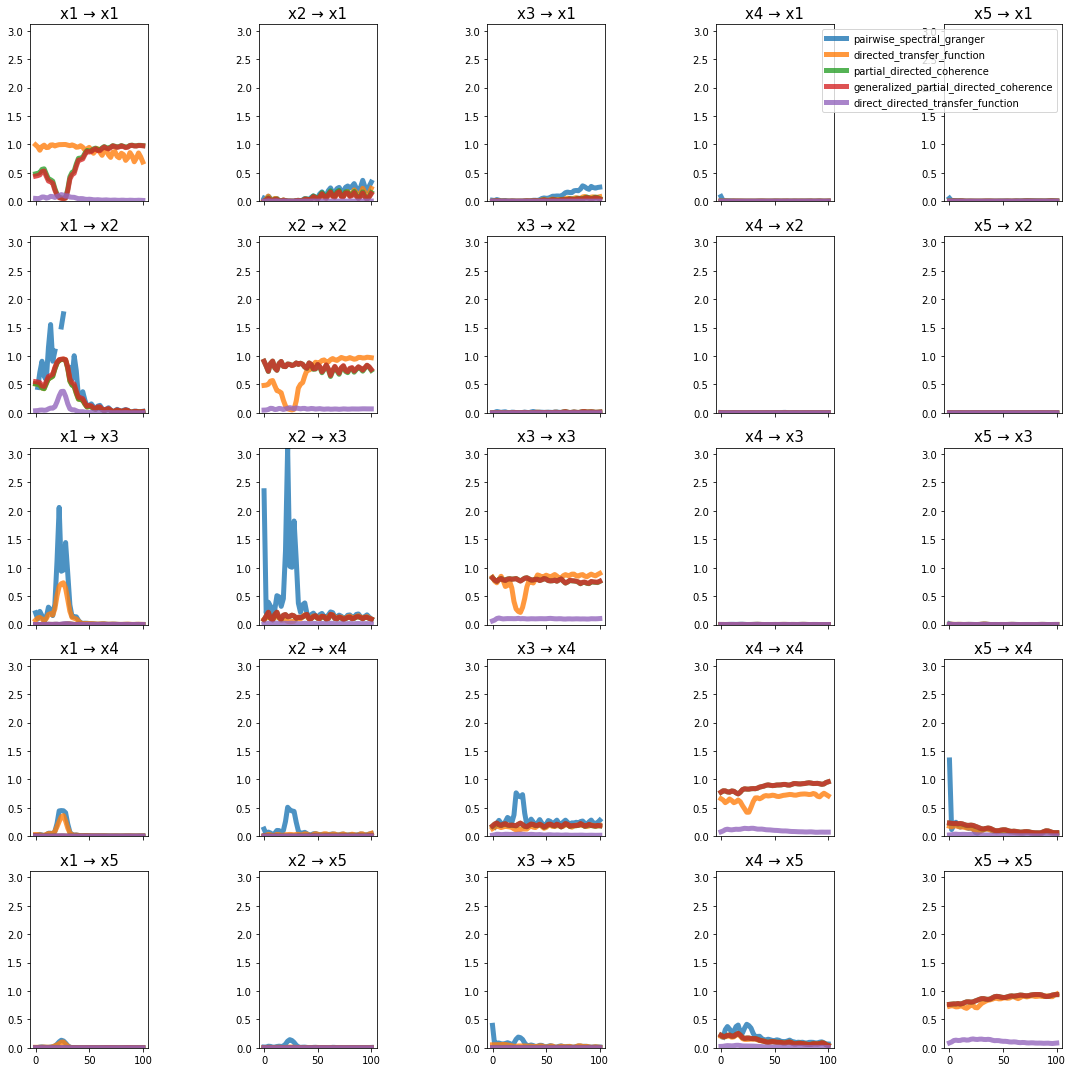

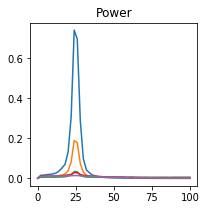

In [9]:
def baccala_example4():
    '''Baccalá, L.A., and Sameshima, K. (2001). Partial directed coherence:
    a new concept in neural structure determination. Biological
    Cybernetics 84, 463–474.
    '''
    sampling_frequency = 200
    n_time_samples, n_lags, n_signals = 100, 2, 5
    coefficients = np.zeros((n_lags, n_signals, n_signals))

    coefficients[0, 0, 0] = 0.95 * np.sqrt(2)
    coefficients[1, 0, 0] = -0.9025
    coefficients[0, 1, 0] = -0.50
    coefficients[1, 2, 1] = 0.40
    coefficients[0, 3, 2] = -0.50
    coefficients[0, 3, 3] = 0.25 * np.sqrt(2)
    coefficients[0, 3, 4] = 0.25 * np.sqrt(2)
    coefficients[0, 4, 3] = -0.25 * np.sqrt(2)
    coefficients[0, 4, 4] = 0.25 * np.sqrt(2)

    noise_covariance = None

    return simulate_MVAR(
        coefficients, noise_covariance=noise_covariance, n_time_samples=n_time_samples,
        n_trials=500, n_burnin_samples=500), sampling_frequency

plot_directional(*baccala_example4(), time_halfbandwidth_product=1)

## Baccala Example 5

> Baccalá, L.A., and Sameshima, K. (2001). Partial directed coherence:
    a new concept in neural structure determination. Biological
    Cybernetics 84, 463–474.
    
 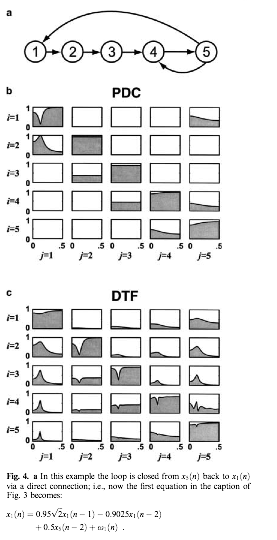

/home/ulianych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


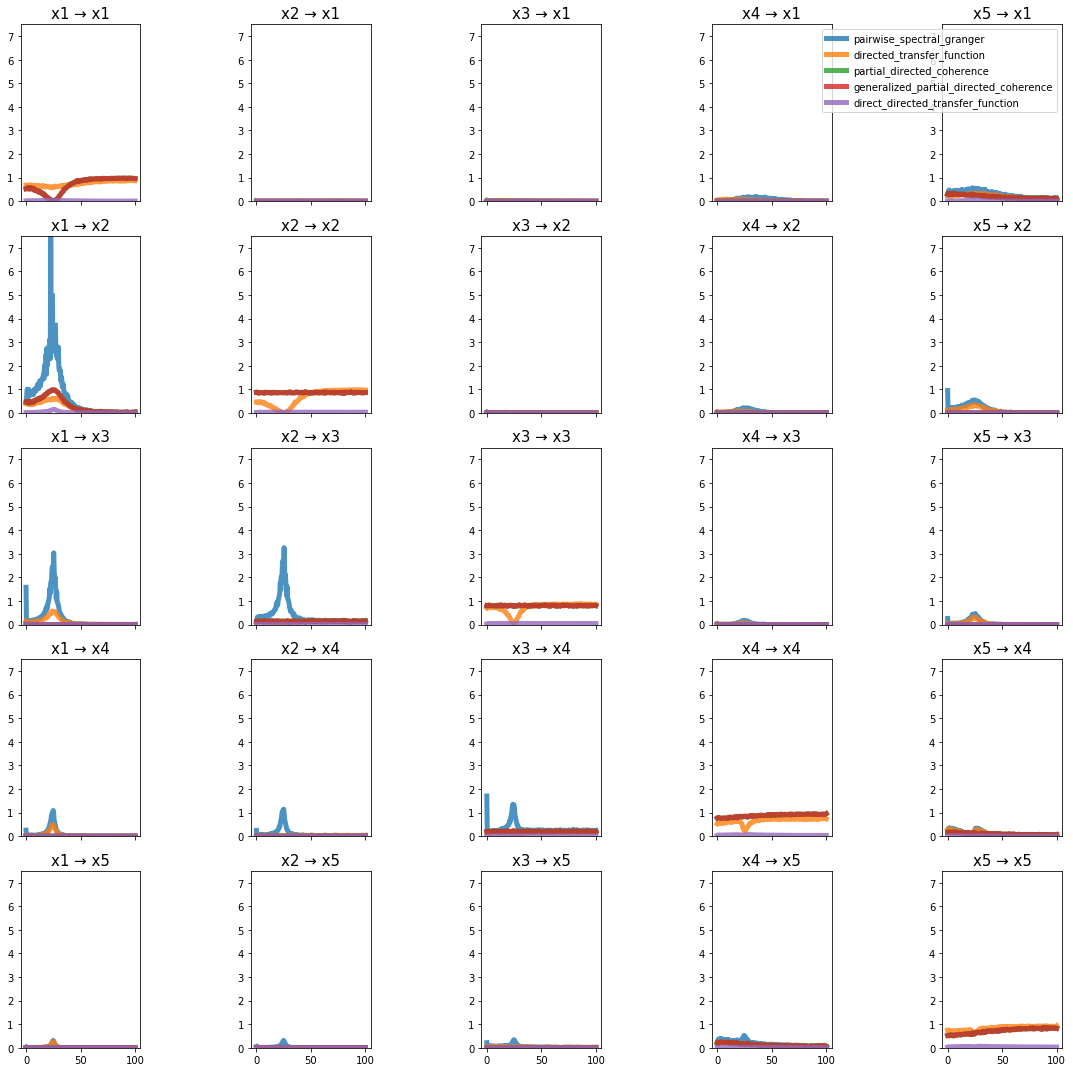

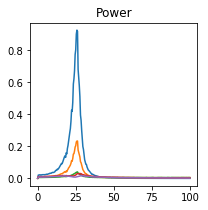

In [10]:
def baccala_example5():
    '''Baccalá, L.A., and Sameshima, K. (2001). Partial directed coherence:
    a new concept in neural structure determination. Biological
    Cybernetics 84, 463–474.
    '''
    sampling_frequency = 200
    n_time_samples, n_lags, n_signals = 510, 2, 5
    coefficients = np.zeros((n_lags, n_signals, n_signals))

    coefficients[0, 0, 0] = 0.95 * np.sqrt(2)
    coefficients[1, 0, 0] = -0.9025
    coefficients[1, 0, 4] = 0.5
    coefficients[0, 1, 0] = -0.50
    coefficients[1, 2, 1] = 0.40
    coefficients[0, 3, 2] = -0.50
    coefficients[0, 3, 3] = 0.25 * np.sqrt(2)
    coefficients[0, 3, 4] = 0.25 * np.sqrt(2)
    coefficients[0, 4, 3] = -0.25 * np.sqrt(2)
    coefficients[0, 4, 4] = 0.25 * np.sqrt(2)

    noise_covariance = None

    return simulate_MVAR(
        coefficients, noise_covariance=noise_covariance, n_time_samples=n_time_samples,
        n_trials=500, n_burnin_samples=500), sampling_frequency

plot_directional(*baccala_example5(), time_halfbandwidth_product=1)

## Baccala Example 6

> Baccalá, L.A., and Sameshima, K. (2001). Partial directed coherence:
    a new concept in neural structure determination. Biological
    Cybernetics 84, 463–474.

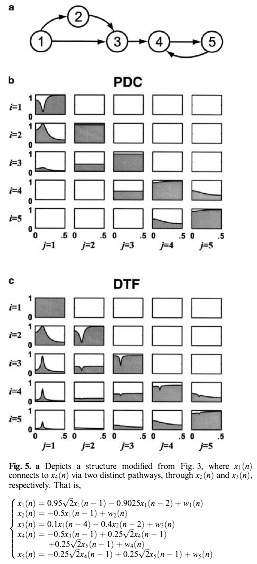

/home/ulianych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


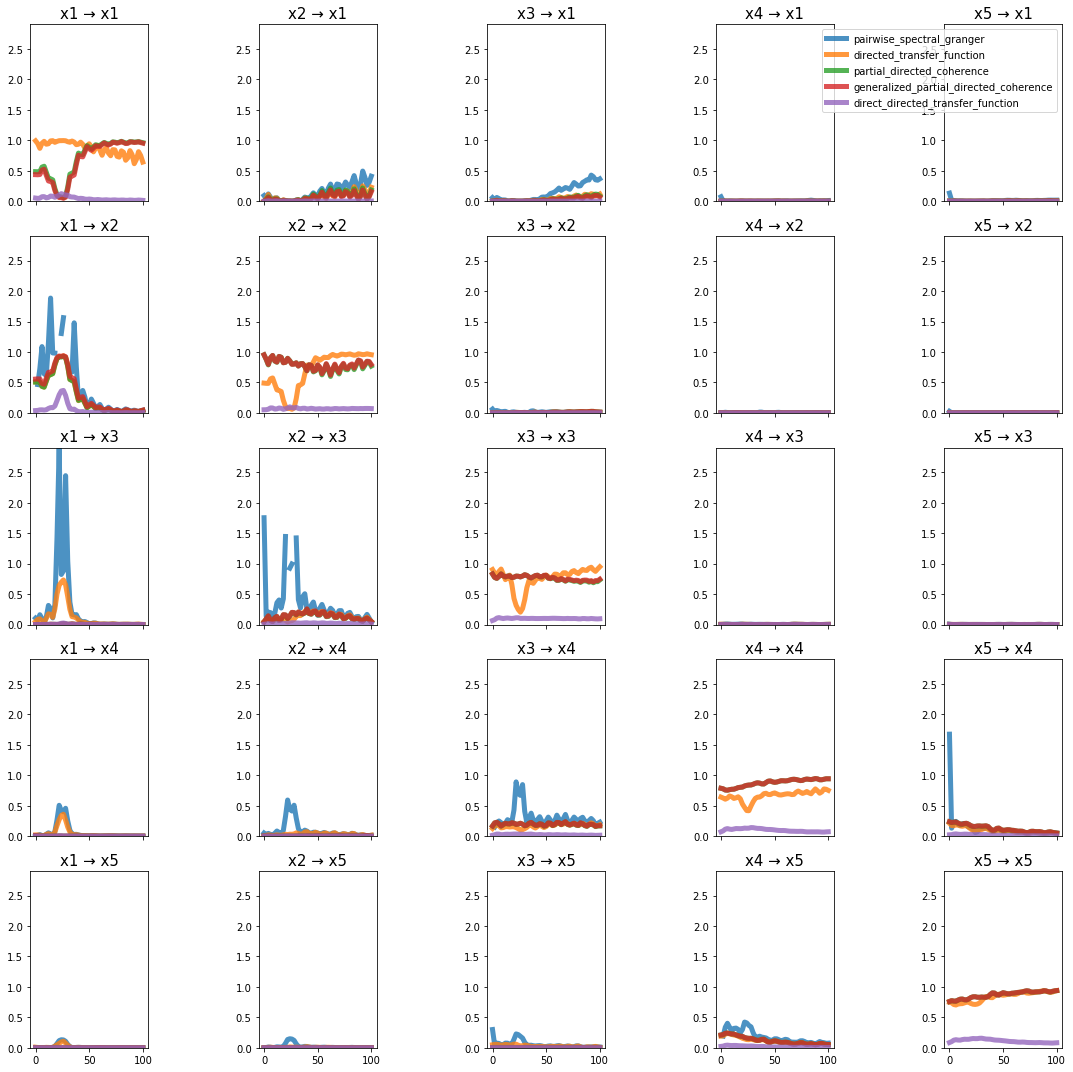

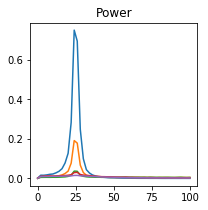

In [11]:
def baccala_example6():
    '''Baccalá, L.A., and Sameshima, K. (2001). Partial directed coherence:
    a new concept in neural structure determination. Biological
    Cybernetics 84, 463–474.
    '''
    sampling_frequency = 200
    n_time_samples, n_lags, n_signals = 100, 4, 5
    coefficients = np.zeros((n_lags, n_signals, n_signals))

    coefficients[0, 0, 0] = 0.95 * np.sqrt(2)
    coefficients[1, 0, 0] = -0.9025
    coefficients[0, 1, 0] = -0.50
    coefficients[3, 2, 1] = 0.10
    coefficients[1, 2, 1] = -0.40
    coefficients[0, 3, 2] = -0.50
    coefficients[0, 3, 3] = 0.25 * np.sqrt(2)
    coefficients[0, 3, 4] = 0.25 * np.sqrt(2)
    coefficients[0, 4, 3] = -0.25 * np.sqrt(2)
    coefficients[0, 4, 4] = 0.25 * np.sqrt(2)

    noise_covariance = None

    return simulate_MVAR(
        coefficients, noise_covariance=noise_covariance, n_time_samples=n_time_samples,
        n_trials=500, n_burnin_samples=500), sampling_frequency

plot_directional(*baccala_example6(), time_halfbandwidth_product=1)

## Ding Example 1

> Ding, M., Chen, Y., and Bressler, S.L. (2006). 17 Granger causality:
    basic theory and application to neuroscience. Handbook of Time Series
    Analysis: Recent Theoretical Developments and Applications 437.
    
$$ x_1 = 0.9x_1(n-1) -0.5x_1(n-2) + w_1 $$
$$ x_2 = 0.8x_2(n-1) -0.5x_2(n-2) + 0.16x_1(n-1) -0.2x_1(n-2) + w_2 $$

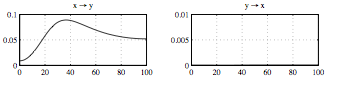

/home/ulianych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


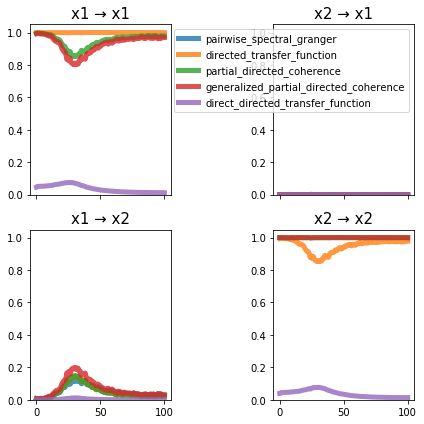

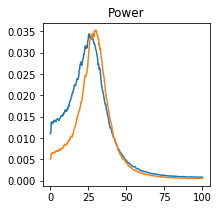

In [12]:
def ding_example1():
    '''Ding, M., Chen, Y., and Bressler, S.L. (2006). 17 Granger causality:
    basic theory and application to neuroscience. Handbook of Time Series
    Analysis: Recent Theoretical Developments and Applications 437.
    '''
    sampling_frequency = 200
    n_time_samples, n_lags, n_signals = 1000, 2, 2
    coefficients = np.zeros((n_lags, n_signals, n_signals))

    coefficients[0, ...] = np.array([[0.90, 0.00],
                                     [0.16, 0.80]])
    coefficients[1, ...] = np.array([[-0.50, 0.00],
                                     [-0.20, -0.50]])

    noise_covariance = np.array([[1.0, 0.4],
                                 [0.4, 0.7]])

    return simulate_MVAR(
        coefficients, noise_covariance=noise_covariance, n_time_samples=n_time_samples,
        n_trials=500, n_burnin_samples=500), sampling_frequency

plot_directional(*ding_example1(), time_halfbandwidth_product=3)

## Ding Example 2a

> Ding, M., Chen, Y., and Bressler, S.L. (2006). 17 Granger causality:
    basic theory and application to neuroscience. Handbook of Time Series
    Analysis: Recent Theoretical Developments and Applications 437.
 
$$ x_1 = 0.8x_1(n-1) - 0.5x_1(n-2) + 0.4x_3(n-1) + 0.2x_2(n-2) + w_1 $$ 
$$ x_2 = 0.9x_2(n-1) - 0.8x_2(n-2) + w_2$$
$$ x_3 = 0.5x_3(n-1) - 0.2x_3(n-2) + 0.5x_2(n-1) + w_3$$
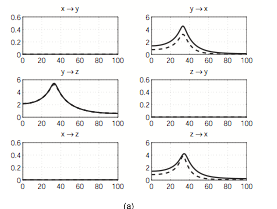

> dashed curves showing the results for the first model and the solid curves for the second model

/home/ulianych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


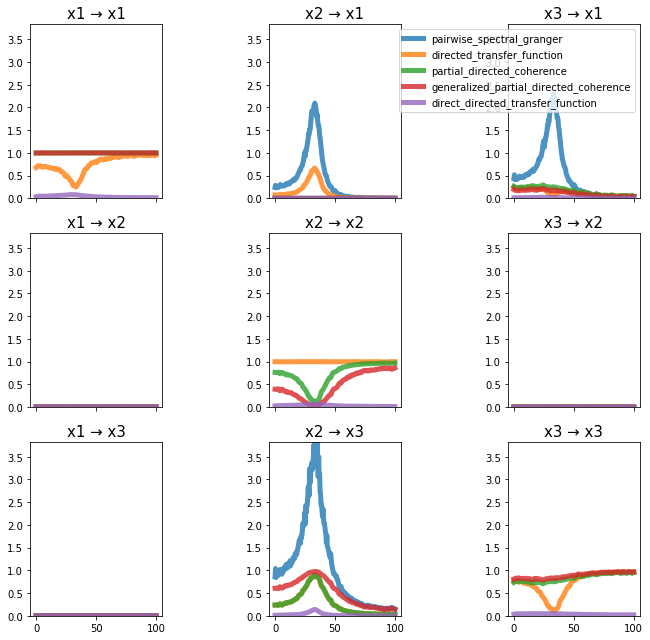

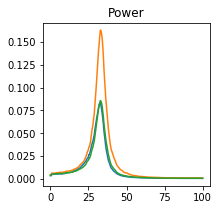

In [13]:
def ding_example2a():
    '''Ding, M., Chen, Y., and Bressler, S.L. (2006). 17 Granger causality:
    basic theory and application to neuroscience. Handbook of Time Series Analysis:
    Recent Theoretical Developments and Applications 437.'''
    sampling_frequency = 200
    n_time_samples, n_lags, n_signals = 500, 2, 3
    coefficients = np.zeros((n_lags, n_signals, n_signals))

    coefficients[0, :, :] = np.array([[0.8, 0.0, 0.4],
                                      [0.0, 0.9, 0.0],
                                      [0.0, 0.5, 0.5]])
    coefficients[1, :, :] = np.array([[-0.5, 0.0, 0.0],
                                      [0.0, -0.8, 0.0],
                                      [0.0, 0.0, -0.2]])

    noise_covariance = np.eye(n_signals) * [0.3, 1, 0.2]

    return simulate_MVAR(
        coefficients, noise_covariance=noise_covariance, n_time_samples=n_time_samples,
        n_trials=500, n_burnin_samples=500), sampling_frequency

plot_directional(*ding_example2a())

## Ding Example 2b

> Ding, M., Chen, Y., and Bressler, S.L. (2006). 17 Granger causality:
    basic theory and application to neuroscience. Handbook of Time Series
    Analysis: Recent Theoretical Developments and Applications 437.
 
$$ x_1 = 0.8x_1(n-1) - 0.5x_1(n-2) + 0.4x_3(n-1) + 0.2x_2(n-2) + w_1 $$ 
$$ x_2 = 0.9x_2(n-1) - 0.8x_2(n-2) + w_2$$
$$ x_3 = 0.5x_3(n-1) - 0.2x_3(n-2) + 0.5x_2(n-1) + w_3$$
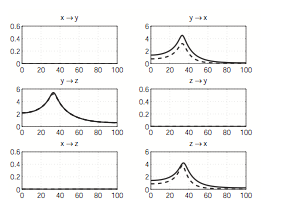

> dashed curves showing the results for the first model and the solid curves for the second model

/home/ulianych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


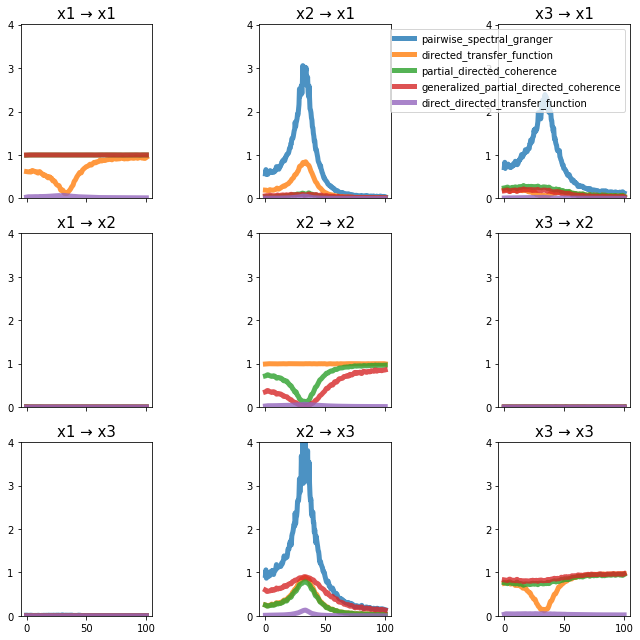

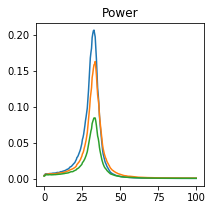

In [14]:
def ding_example2b():
    '''Ding, M., Chen, Y., and Bressler, S.L. (2006). 17 Granger causality:
    basic theory and application to neuroscience. Handbook of Time Series Analysis:
    Recent Theoretical Developments and Applications 437.'''
    sampling_frequency = 200
    n_time_samples, n_lags, n_signals = 500, 2, 3
    coefficients = np.zeros((n_lags, n_signals, n_signals))

    coefficients[0, :, :] = np.array([[0.8, 0.0, 0.4],
                                      [0.0, 0.9, 0.0],
                                      [0.0, 0.5, 0.5]])
    coefficients[1, :, :] = np.array([[-0.5, 0.2, 0.0],
                                      [0.0, -0.8, 0.0],
                                      [0.0, 0.0, -0.2]])

    noise_covariance = np.eye(n_signals) * [0.3, 1.0, 0.2]

    return simulate_MVAR(
        coefficients, noise_covariance=noise_covariance, n_time_samples=n_time_samples,
        n_trials=500, n_burnin_samples=100), sampling_frequency

plot_directional(*ding_example2b(), time_halfbandwidth_product=2)

## Ding Example 3

> Ding, M., Chen, Y., and Bressler, S.L. (2006). 17 Granger causality:
    basic theory and application to neuroscience. Handbook of Time Series Analysis:
    Recent Theoretical Developments and Applications 437.
    
$$ x_1 = 0.95\sqrt2x_1(n-1) - 0.9025x_1(n-2) + w_1 $$
$$ x_2 = 0.5x_1(n-2) + w_2 $$
$$ x_3 = -0.4x_1(n-3) + w_3 $$
$$ x_4 = -0.5x_1(n-2) + 0.25\sqrt2x_4(n-1) + 0.25\sqrt2x_5(n-1) + w_4 $$
$$ x_5 = 0.25\sqrt2x_4(n-1) + 0.25\sqrt2x_5(n-1) + w_5 $$

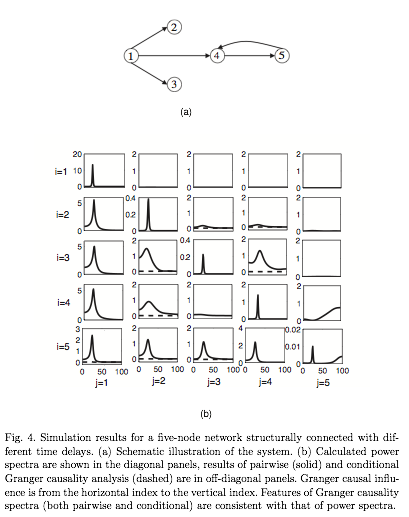

/home/ulianych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


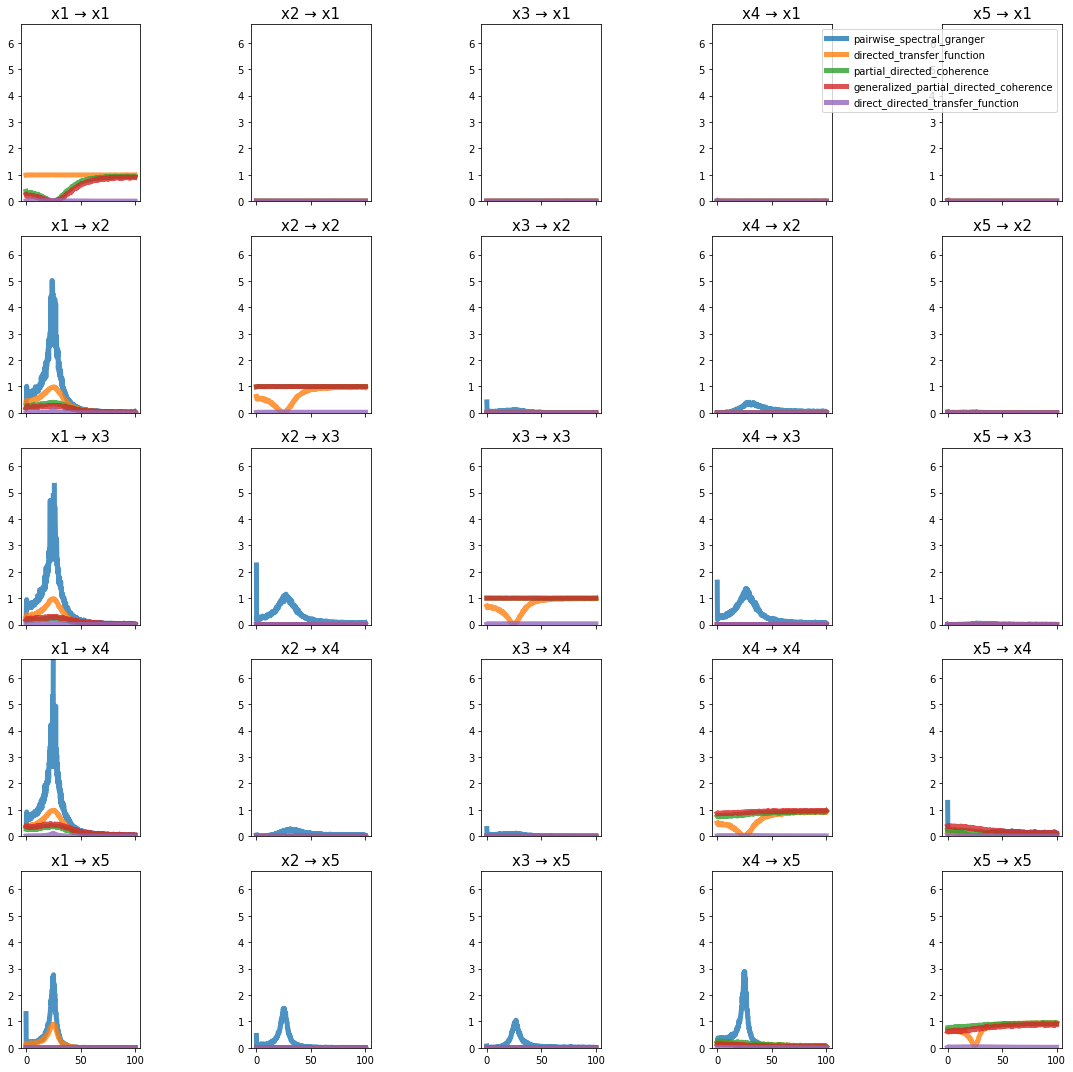

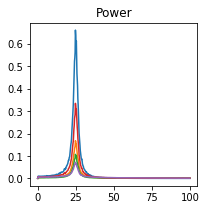

In [15]:
def ding_example3():
    '''Ding, M., Chen, Y., and Bressler, S.L. (2006). 17 Granger causality:
    basic theory and application to neuroscience. Handbook of Time Series Analysis:
    Recent Theoretical Developments and Applications 437.'''
    sampling_frequency = 200
    n_time_samples, n_lags, n_signals = 1000, 3, 5
    coefficients = np.zeros((n_lags, n_signals, n_signals))

    coefficients[0, 0, 0] = 0.95 * np.sqrt(2)
    coefficients[1, 0, 0] = -0.9025

    coefficients[1, 1, 0] = 0.50
    coefficients[2, 2, 0] = -0.40

    coefficients[1, 3, 0] = -0.50
    coefficients[0, 3, 3] = 0.25 * np.sqrt(2)
    coefficients[0, 3, 4] = 0.25 * np.sqrt(2)

    coefficients[0, 4, 3] = -0.25 * np.sqrt(2)
    coefficients[0, 4, 4] = 0.25 * np.sqrt(2)

    noise_covariance = np.eye(n_signals) * [0.6, 0.5, 0.3, 0.3, 0.6]

    return simulate_MVAR(
        coefficients, noise_covariance=noise_covariance, n_time_samples=n_time_samples,
        n_trials=500, n_burnin_samples=500), sampling_frequency

plot_directional(*ding_example3(), time_halfbandwidth_product=1)

## Nedungadi Example 1

> Nedungadi, A.G., Ding, M., and Rangarajan, G. (2011). Block coherence: a method for measuring the interdependence between two blocks of neurobiological time series. Biological Cybernetics 104, 197–207.

/home/ulianych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


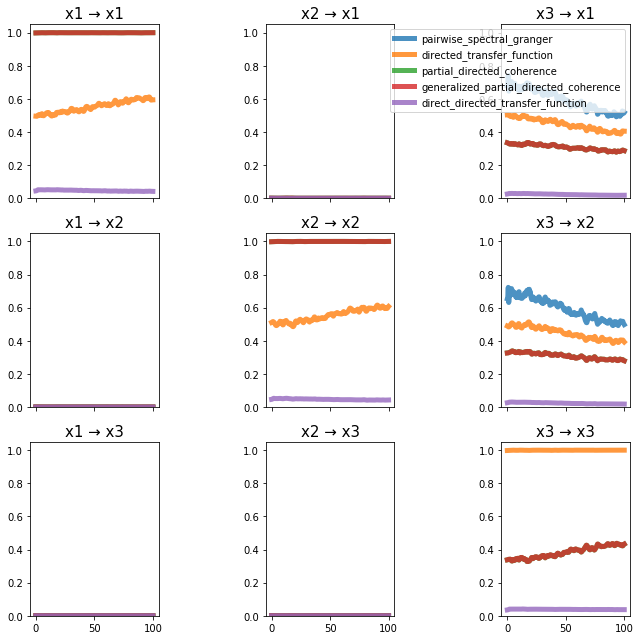

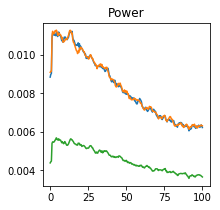

In [16]:
def Nedungadi_example1():
    '''Nedungadi, A.G., Ding, M., and Rangarajan, G. (2011).
    Block coherence: a method for measuring the interdependence
    between two blocks of neurobiological time series. Biological
    Cybernetics 104, 197–207.
    '''
    sampling_frequency = 200
    n_time_samples, n_lags, n_signals = 500, 1, 3
    coefficients = np.zeros((n_lags, n_signals, n_signals))

    coefficients[0, :, :] = np.array([[0.1, 0.0, 0.9],
                                      [0.0, 0.1, 0.9],
                                      [0.0, 0.0, 0.1]])

    noise_covariance = np.array([[0.9, 0.6, 0.0],
                                 [0.6, 0.9, 0.0],
                                 [0.0, 0.0, 0.9]])

    return simulate_MVAR(
        coefficients, noise_covariance=noise_covariance, n_time_samples=n_time_samples,
        n_trials=1000, n_burnin_samples=500), sampling_frequency

plot_directional(*Nedungadi_example1(), time_halfbandwidth_product=3)

## Nedungadi Example 2

> Nedungadi, A.G., Ding, M., and Rangarajan, G. (2011). Block coherence: a method for measuring the interdependence between two blocks of neurobiological time series. Biological Cybernetics 104, 197–207.

/home/ulianych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


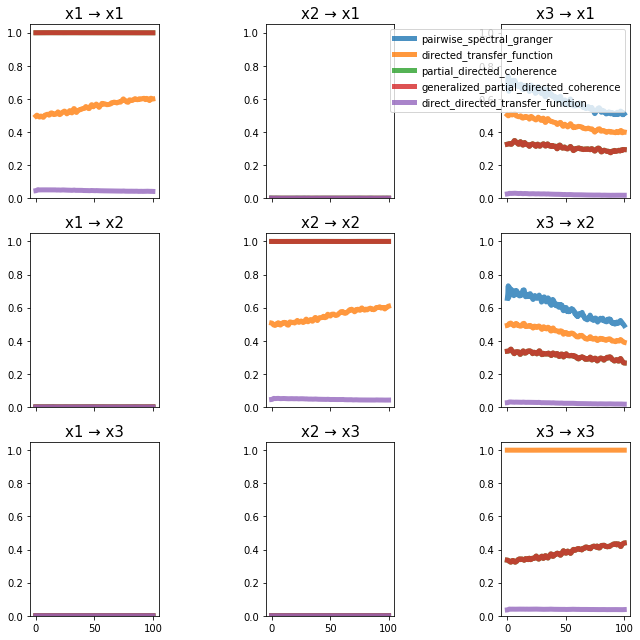

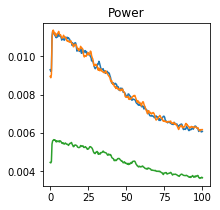

In [17]:
def Nedungadi_example2():
    '''Nedungadi, A.G., Ding, M., and Rangarajan, G. (2011).
    Block coherence: a method for measuring the interdependence
    between two blocks of neurobiological time series. Biological
    Cybernetics 104, 197–207.
    '''
    sampling_frequency = 200
    n_time_samples, n_lags, n_signals = 500, 1, 3
    coefficients = np.zeros((n_lags, n_signals, n_signals))

    coefficients[0, :, :] = np.array([[0.1, 0.0, 0.9],
                                      [0.0, 0.1, 0.9],
                                      [0.0, 0.0, 0.1]])

    noise_covariance = np.array([[0.9, 0.0, 0.0],
                                 [0.0, 0.9, 0.0],
                                 [0.0, 0.0, 0.9]])

    return simulate_MVAR(
        coefficients, noise_covariance=noise_covariance, n_time_samples=n_time_samples,
        n_trials=1000, n_burnin_samples=500), sampling_frequency

plot_directional(*Nedungadi_example2(), time_halfbandwidth_product=3)

## Wen Example 1

> Wen, X., Rangarajan, G., and Ding, M. (2013). Multivariate Granger causality: an estimation framework based on factorization of the spectral density matrix. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences 371, 20110610–20110610.

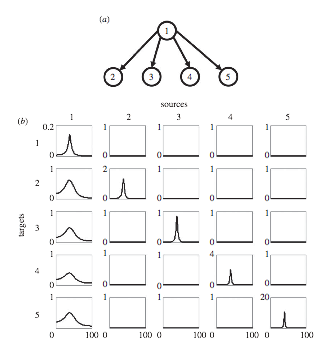

/home/ulianych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


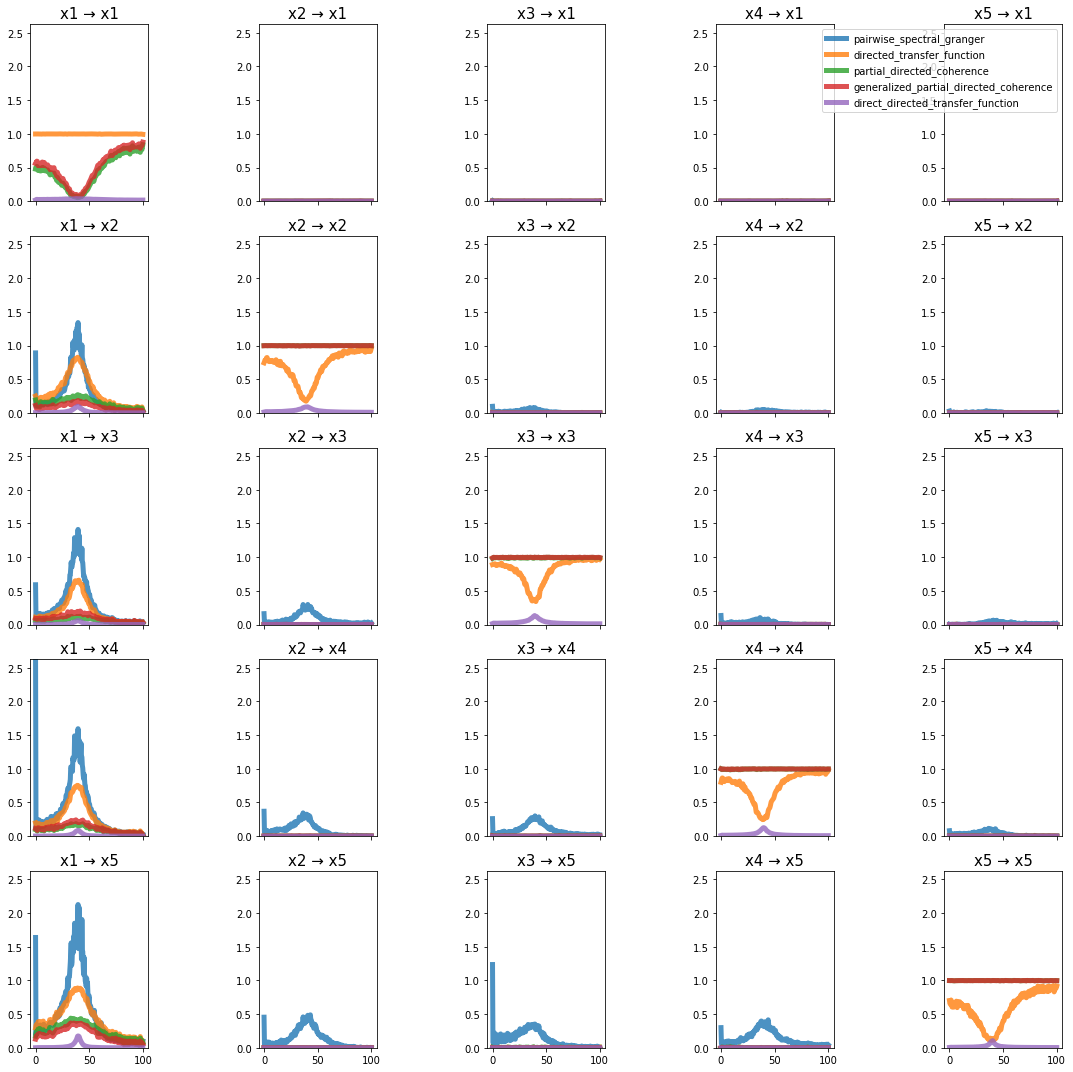

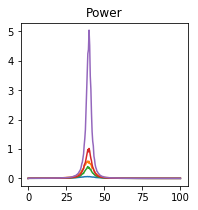

In [18]:
def Wen_example1():
    sampling_frequency = 200
    n_time_samples, n_lags, n_signals = 500, 4, 5
    coefficients = np.zeros((n_lags, n_signals, n_signals))

    coefficients[0, 0, 0] = 0.55
    coefficients[1, 0, 0] = -0.70
    coefficients[0, 1, 1] = 0.56
    coefficients[1, 1, 1] = -0.75
    coefficients[0, 1, 0] = 0.60
    coefficients[0, 2, 2] = 0.57
    coefficients[1, 2, 2] = -0.80
    coefficients[1, 2, 0] = 0.40
    coefficients[0, 3, 3] = 0.58
    coefficients[1, 3, 3] = -0.85
    coefficients[2, 3, 0] = 0.50
    coefficients[0, 4, 4] = 0.59
    coefficients[1, 4, 4] = -0.90
    coefficients[3, 4, 0] = 0.80
    

    noise_covariance = np.eye(n_signals) * [1.0, 2.0, 0.8, 1.0, 1.5]

    return simulate_MVAR(
        coefficients, noise_covariance=noise_covariance, n_time_samples=n_time_samples,
        n_trials=500, n_burnin_samples=500), sampling_frequency

plot_directional(*Wen_example1(), time_halfbandwidth_product=1)

## Wen Example 2

> Wen, X., Rangarajan, G., and Ding, M. (2013). Multivariate Granger causality: an estimation framework based on factorization of the spectral density matrix. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences 371, 20110610–20110610.

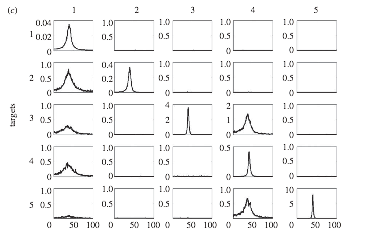

/home/ulianych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


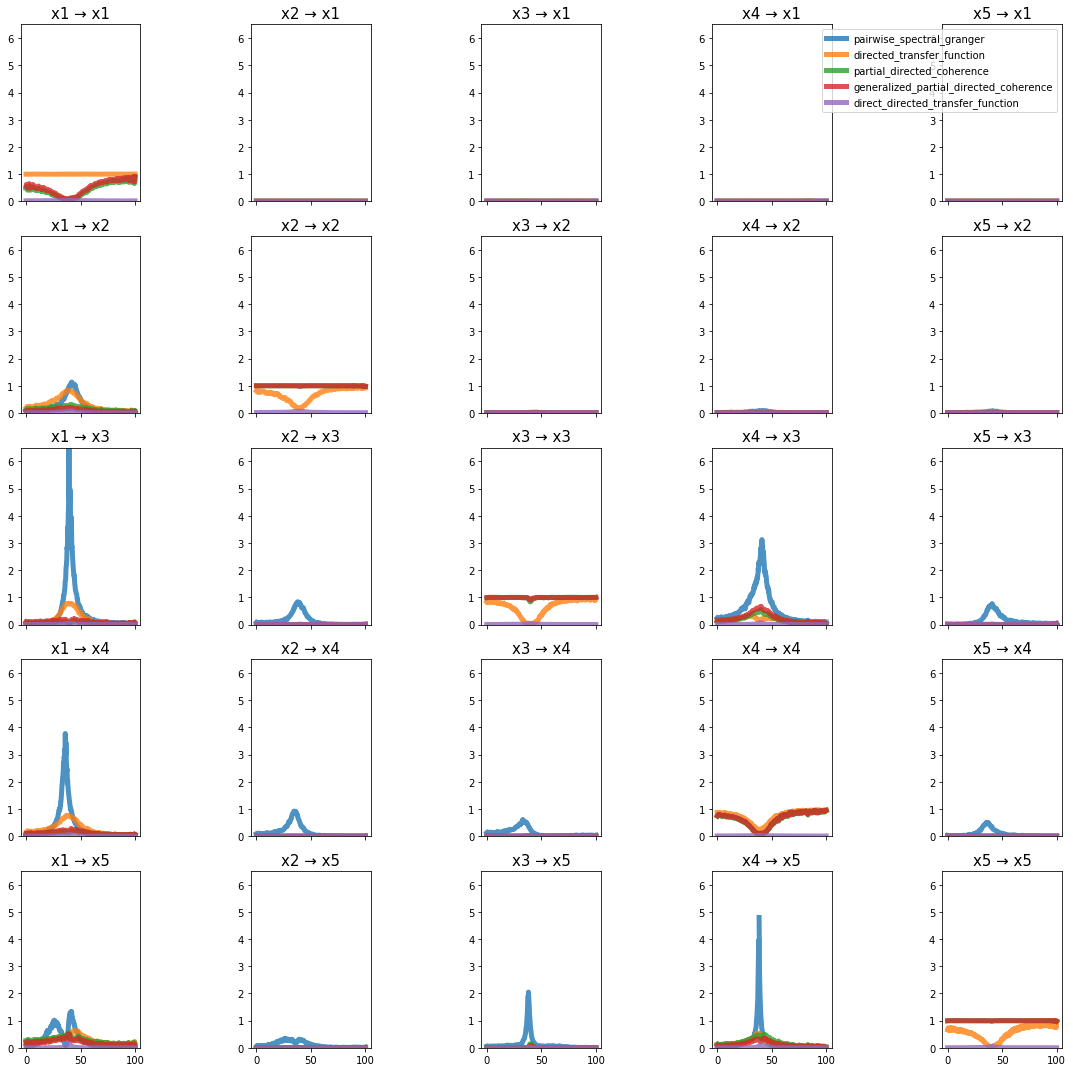

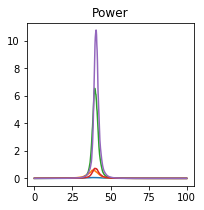

In [19]:
def Wen_example2():
    sampling_frequency = 200
    n_time_samples, n_lags, n_signals = 1000, 4, 5
    coefficients = np.zeros((n_lags, n_signals, n_signals))

    coefficients[0, 0, 0] = 0.55
    coefficients[1, 0, 0] = -0.70
    coefficients[0, 1, 1] = 0.56
    coefficients[1, 1, 1] = -0.75
    coefficients[0, 1, 0] = 0.60
    coefficients[0, 2, 2] = 0.57
    coefficients[1, 2, 2] = -0.80
    coefficients[1, 2, 0] = 0.40
    coefficients[0, 3, 3] = 0.58
    coefficients[1, 3, 3] = -0.85
    coefficients[2, 3, 0] = 0.50
    coefficients[0, 4, 4] = 0.59
    coefficients[1, 4, 4] = -0.90
    coefficients[3, 4, 0] = 0.80
    
    coefficients[0, 2, 3] = -0.50
    coefficients[0, 4, 3] = -0.50
    
    noise_covariance = np.ones((n_signals, n_signals)) * 0.5
    diagonal_ind = np.arange(0, n_signals)
    noise_covariance[diagonal_ind, diagonal_ind] = [1.0, 2.0, 0.8, 1.0, 1.5]

    return simulate_MVAR(
        coefficients, noise_covariance=noise_covariance, n_time_samples=n_time_samples,
        n_trials=200, n_burnin_samples=100), sampling_frequency

plot_directional(*Wen_example2(), time_halfbandwidth_product=3)

## Dhamala Example 1

> Dhamala, M., Rangarajan, G., and Ding, M. (2008). Analyzing information flow in brain networks with nonparametric Granger causality. NeuroImage 41, 354–362.

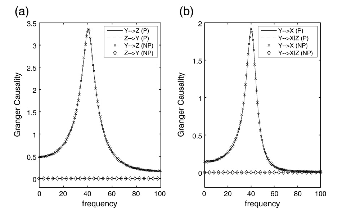

/home/ulianych/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


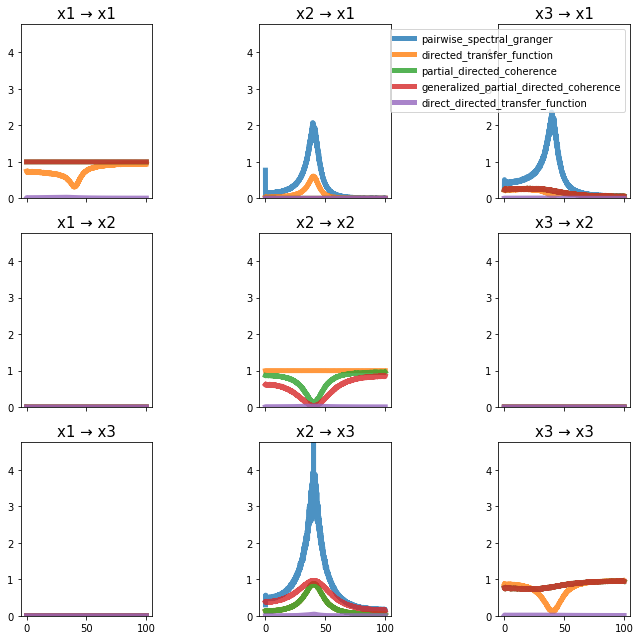

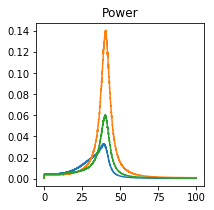

In [20]:
def Dhamala_example1():
    sampling_frequency = 200
    n_time_samples, n_lags, n_signals = 4000, 2, 3
    coefficients = np.zeros((n_lags, n_signals, n_signals))
    
    coefficients[0, 0, 0] = 0.80
    coefficients[1, 0, 0] = -0.50
    coefficients[0, 0, 2] = 0.40
    coefficients[0, 1, 1] = 0.53
    coefficients[1, 1, 1] = -0.80
    coefficients[0, 2, 2] = 0.50
    coefficients[1, 2, 2] = -0.20
    coefficients[0, 2, 1] = 0.50
    
    noise_covariance = np.eye(n_signals) * [0.25, 1.00, 0.25]
    return simulate_MVAR(
        coefficients, noise_covariance=noise_covariance, n_time_samples=n_time_samples,
        n_trials=4000, n_burnin_samples=1000), sampling_frequency

plot_directional(*Dhamala_example1(), time_halfbandwidth_product=1)

## Dhamala Example 2

> Dhamala, M., Rangarajan, G., and Ding, M. (2008). Analyzing information flow in brain networks with nonparametric Granger causality. NeuroImage 41, 354–362.

In [21]:
def Dhamala_example2a():
    sampling_frequency = 200
    n_time_samples, n_lags, n_signals = 450, 2, 2
    coefficients = np.zeros((n_lags, n_signals, n_signals))
    
    coefficients[0, 0, 0] = 0.53
    coefficients[1, 0, 0] = -0.80
    coefficients[0, 0, 1] = 0.50
    coefficients[0, 1, 1] = 0.53
    coefficients[1, 1, 1] = -0.80
    coefficients[0, 1, 0] = 0.00
    
    noise_covariance = np.eye(n_signals) * [0.25, 0.25]
    return simulate_MVAR(
        coefficients, noise_covariance=noise_covariance, n_time_samples=n_time_samples,
        n_trials=1000, n_burnin_samples=1000), sampling_frequency

def Dhamala_example2b():
    sampling_frequency = 200
    n_time_samples, n_lags, n_signals = 450, 2, 2
    coefficients = np.zeros((n_lags, n_signals, n_signals))
    
    coefficients[0, 0, 0] = 0.53
    coefficients[1, 0, 0] = -0.80
    coefficients[0, 0, 1] = 0.00
    coefficients[0, 1, 1] = 0.53
    coefficients[1, 1, 1] = -0.80
    coefficients[0, 1, 0] = 0.50
    
    noise_covariance = np.eye(n_signals) * [0.25, 0.25]
    return simulate_MVAR(
        coefficients, noise_covariance=noise_covariance, n_time_samples=n_time_samples,
        n_trials=1000, n_burnin_samples=1000), sampling_frequency

time_series1, sampling_frequency = Dhamala_example2a()
time_series2, _ = Dhamala_example2b()
time_series = np.concatenate((time_series1, time_series2), axis=0)

time_halfbandwidth_product = 1

m = Multitaper(time_series,
               sampling_frequency=sampling_frequency,
               time_halfbandwidth_product=time_halfbandwidth_product,
               start_time=0,
               time_window_duration=0.500,
               time_window_step=0.250)
c = Connectivity.from_multitaper(m)
granger = c.pairwise_spectral_granger_prediction()

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

ax[0].pcolormesh(c.time, c.frequencies, granger[..., :, 0, 1].T, cmap='viridis');
ax[0].set_title('x1 -> x2')
ax[0].set_ylabel('Frequency')
ax[1].pcolormesh(c.time, c.frequencies, granger[..., :, 1, 0].T, cmap='viridis');
ax[1].set_title('x2 -> x1');
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Frequency');

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fecf8710a60> (for post_execute):


TypeError: Cannot cast array data from dtype('complex128') to dtype('int64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('int64') according to the rule 'safe'

<Figure size 432x288 with 2 Axes>

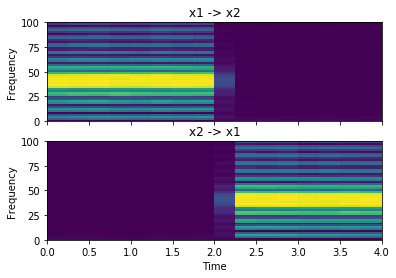

In [22]:
dtf = c.directed_transfer_function()

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

ax[0].pcolormesh(c.time, c.frequencies, dtf[..., :, 0, 1].T, cmap='viridis');
ax[0].set_title('x1 -> x2')
ax[0].set_ylabel('Frequency')
ax[1].pcolormesh(c.time, c.frequencies, dtf[..., :, 1, 0].T, cmap='viridis');
ax[1].set_title('x2 -> x1');
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Frequency');

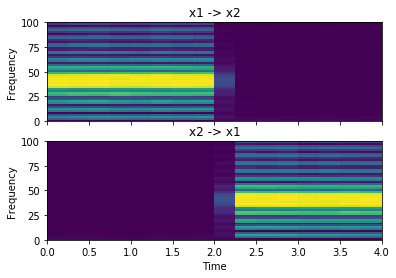

In [23]:
pdc = c.partial_directed_coherence()

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

ax[0].pcolormesh(c.time, c.frequencies, pdc[..., :, 0, 1].T, cmap='viridis');
ax[0].set_title('x1 -> x2')
ax[0].set_ylabel('Frequency')
ax[1].pcolormesh(c.time, c.frequencies, pdc[..., :, 1, 0].T, cmap='viridis');
ax[1].set_title('x2 -> x1');
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Frequency');